<a href="https://colab.research.google.com/github/jiananyang81/QMSS-5074/blob/main/assignment%20%232.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

Archive:  /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip
replace COVID-19_Radiography_Dataset/COVID.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-2502.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-378.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2460.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-872.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2276.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1232.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3306.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3117.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3219.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-28.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2256.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-965.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-406.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2866.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1116.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID

In [ ]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]


In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

4032

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
len(fnames[2])

1344

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


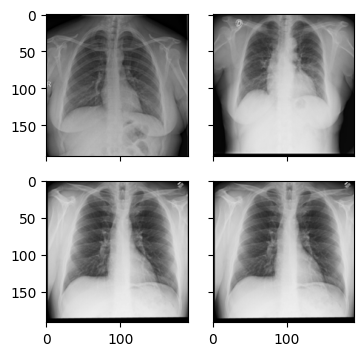

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][1])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

The dataset can be instrumental in interpreting COVID-19-related abnormalities in X-ray images, thereby improving the accuracy and efficiency of diagnosis. Furthermore, the model can facilitate early screening and diagnosis of COVID-19 patients, particularly in regions with limited access to PCR testing or where swift reporting is imperative. Leveraging X-ray data to rapidly identify COVID-19 cases can enable healthcare centers to make informed decisions regarding resource allocation and patient management. Finally, in telemedicine settings where physical assessment is challenging, the model can serve as a preliminary diagnostic tool for remote healthcare providers. Ultimately, employing the dataset and utilizing models for early diagnosis of COVID-19 cases can have far-reaching implications for the management of the pandemic.

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  # Fitting the CNN to the Training set
  model.fit(X_train, y_train,
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 369s 5s/step - loss: 0.8112 - accuracy: 0.6072 - val_loss: 0.6717 - val_accuracy: 0.7231


In [ ]:
model.save("model1.h5", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.8/975.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 115.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=True)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                   

In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=939589d992c97cec3978458fe9991fd0527f256fb94401a29c86ed27273c7368
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 64s 2s/step


In [ ]:
apiurl='https://w2zzwqfobi.execute-api.us-east-2.amazonaws.com/prod/m'

from aimodelshare.playground import ModelPlayground
experiment=ModelPlayground(playground_url=apiurl, task_type="classification")

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)



Modelshare.ai Username:··········
Modelshare.ai Password:··········
Modelshare.ai login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model= model,
                                 preprocessor = None,
                                 prediction_submission=prediction_labels)

Timeout: Model to ONNX conversion is taking longer than expected. This can be the case for big models.
Do you want to keep trying (1) or submit predictions only (2)? 2

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 7.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3867


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,model_type,username,version
0,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,7
1,66.69%,65.04%,72.19%,66.69%,unknown,unknown,mikedparrott,1
2,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,2
3,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,3
4,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,4
5,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,5
6,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,6


In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model2 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='valid', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='valid', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  # Fitting the CNN to the Training set
  model2.fit(X_train, y_train,
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 95s 1s/step - loss: 0.8855 - accuracy: 0.5370 - val_loss: 0.6357 - val_accuracy: 0.7213


In [ ]:
model2.save("model2.h5", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Reload model and data
import tensorflow as tf
model2 = tf.keras.models.load_model('model2.h5',compile=False)
model2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 190, 190, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 190, 190, 32)      1056      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 95, 95, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 93, 93, 32)        9248      
                                                                 
 conv2d_13 (Conv2D)          (None, 93, 93, 32)        1056      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                 

In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model= model2,
                                 preprocessor = None,
                                 prediction_submission=prediction_labels)

Timeout: Model to ONNX conversion is taking longer than expected. This can be the case for big models.
Do you want to keep trying (1) or submit predictions only (2)? 2

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 8.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3867


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,model_type,username,version
0,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,7
1,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,8
2,66.69%,65.04%,72.19%,66.69%,unknown,unknown,mikedparrott,1
3,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,2
4,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,3
5,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,4
6,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,5
7,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,6


In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model3 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)
    tf.keras.layers.Conv1D(kernel_size=3, filters=32, padding='causal', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv1D(kernel_size=1, filters=32, padding='causal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv1D(kernel_size=3, filters=32, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(kernel_size=1, filters=32, padding='causal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv1D(kernel_size=3, filters=32, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(kernel_size=1, filters=32, padding='causal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv1D(kernel_size=3, filters=64, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(kernel_size=1, filters=64, padding='causal', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv1D(kernel_size=3, filters=128, padding='causal', activation='relu'),
    tf.keras.layers.Conv1D(kernel_size=1, filters=128, padding='causal', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  # Fitting the CNN to the Training set
  model3.fit(X_train, y_train,
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 86s 1s/step - loss: 0.7892 - accuracy: 0.6227 - val_loss: 0.5776 - val_accuracy: 0.7322


In [ ]:
model.save("model3.h5", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Reload model and data
import tensorflow as tf
model3 = tf.keras.models.load_model('model3.h5',compile=False)
model3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                   

In [ ]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model= model3,
                                 preprocessor = None,
                                 prediction_submission=prediction_labels)

Timeout: Model to ONNX conversion is taking longer than expected. This can be the case for big models.
Do you want to keep trying (1) or submit predictions only (2)? 2

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 9.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3867


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,model_type,username,version
0,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,7
1,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,8
2,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,9
3,66.69%,65.04%,72.19%,66.69%,unknown,unknown,mikedparrott,1
4,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,2
5,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,3
6,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,4
7,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,5
8,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,6


In [ ]:
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [ ]:
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model4 = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint

  mc = ModelCheckpoint('best_model_vgg16.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

  model4.fit(X_train, y_train,
          epochs = 1, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

69/69 [==============================] - ETA: 0s - loss: 1.1575 - acc: 0.5985
Epoch 00001: val_acc improved from -inf to 0.80146, saving model to best_model_vgg16.h5
69/69 [==============================] - 872s 13s/step - loss: 1.1575 - acc: 0.5985 - val_loss: 0.6842 - val_acc: 0.8015 - lr: 0.0100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("model4.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model_vgg16 = tf.keras.models.load_model('model3.h5',compile=False)
model_vgg16.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                   

In [ ]:
# Submit Model 4 to Competition Leaderboard
experiment.submit_model(model= model_vgg16,
                                 preprocessor = None,
                                 prediction_submission=prediction_labels)

Timeout: Model to ONNX conversion is taking longer than expected. This can be the case for big models.
Do you want to keep trying (1) or submit predictions only (2)? 2

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 10.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3867


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,model_type,username,version
0,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,7
1,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,8
2,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,9
3,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,10
4,66.69%,65.04%,72.19%,66.69%,unknown,unknown,mikedparrott,1
5,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,2
6,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,3
7,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,4
8,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,5
9,59.64%,48.26%,40.79%,59.61%,unknown,unknown,jiananyang81,6


My four models all performed similarly.I tried the padding "same", "valid" and "causal", which is only for 1D. I believe that model 4, the VGG16 model, performed better than others.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_dir = os.path.join(base_path,'Train')
validation_dir = os.path.join(base_path, 'Test')

In [ ]:
print(train_dir)

COVID-19_Radiography_Dataset/Train


In [ ]:
batch_size = 128
epochs = 1
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory= train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

FileNotFoundError: ignored

There is no train file in the zip file， so it cannot be run.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

FileNotFoundError: ignored

There is no test file in the zip file， so it cannot be run.

In [ ]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu',
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(216, activation='relu'),
    Dense(3)
])

In [ ]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

In [ ]:
model_new.fit(
    train_data_gen,
    epochs=1,
)

In [ ]:
# Reload model and data
import tensorflow as tf
model5 = tf.keras.models.load_model('model5.h5',compile=False)
model5.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model5.summary()

In [ ]:
# Submit Model 5 to Competition Leaderboard
experiment.submit_model(model= model5,
                                 preprocessor = None,
                                 prediction_submission=prediction_labels)

In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

As train and test data are not available(they are not in the zip file), I cannot determine the model's performance. I have completed the coding part, and I will be able to provide the result once I have the training and testing data.